In [2]:
import pandas as pd
import numpy as np
import time
import math
import tensorflow as tf
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy, binary_crossentropy
from keras.optimizers import Adam
import plotly.graph_objs as go
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from keras.models import Model
import keras
import keras.backend as K
import h5py
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.utils import plot_model
from sklearn.utils import shuffle

init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


### Data Preparation

#### Chicago Crime Dataset

In [ ]:
def generate_batches(l, n): 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 
        
# (batch_size, days, lat_bin, lon_bin, crime_t)
days = 30
lat_b = 16
lon_b = 16
crime_t = 1

chicago_crime = pd.read_csv('https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD')

In [11]:
chicago_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7491320 entries, 0 to 7491319
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Case Number           object 
 2   Date                  object 
 3   Block                 object 
 4   IUCR                  object 
 5   Primary Type          object 
 6   Description           object 
 7   Location Description  object 
 8   Arrest                bool   
 9   Domestic              bool   
 10  Beat                  int64  
 11  District              float64
 12  Ward                  float64
 13  Community Area        float64
 14  FBI Code              object 
 15  X Coordinate          float64
 16  Y Coordinate          float64
 17  Year                  int64  
 18  Updated On            object 
 19  Latitude              float64
 20  Longitude             float64
 21  Location              object 
dtypes: bool(2), float64(7), int64(3), object(1

In [12]:
chicago_crime.Date = pd.to_datetime(chicago_crime.Date)

In [9]:
chicago_crime.sort_values(by="Date").head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
260319,12312332,JE165297,2019-01-01,009XX W 76TH ST,0266,CRIMINAL SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,...,17.0,71,02,1174671.0,1877106.0,2019,04/29/2021 04:49:22 PM,41.818171,-87.634761,"(41.818171324, -87.634760982)"
260732,12499305,JE393359,2019-01-01,026XX S CALIFORNIA AVE,1140,DECEPTIVE PRACTICE,EMBEZZLEMENT,GOVERNMENT BUILDING / PROPERTY,False,False,...,24.0,30,12,NaN,NaN,2019,10/02/2021 04:47:29 PM,NaN,NaN,NaN
14509,11566200,JC116315,2019-01-01,072XX S EAST END AVE,0320,ROBBERY,STRONGARM - NO WEAPON,APARTMENT,False,True,...,7.0,43,03,1188788.0,1857344.0,2019,01/18/2019 09:37:14 AM,41.763616,-87.583608,"(41.763616341, -87.58360812)"
260739,11737723,JC323962,2019-01-01,028XX S ST LOUIS AVE,1754,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,APARTMENT,False,True,...,22.0,30,02,1153496.0,1884904.0,2019,10/13/2021 04:47:43 PM,41.840016,-87.712231,"(41.840016176, -87.712231415)"
253039,11968763,JD136487,2019-01-01,020XX N KOSTNER AVE,0810,THEFT,OVER $500,APARTMENT,False,True,...,35.0,20,06,1146722.0,1913364.0,2019,02/05/2020 03:52:05 PM,41.918245,-87.736363,"(41.918245482, -87.736363)"


In [7]:
chicago_crime = chicago_crime[chicago_crime['Date'].dt.year >= 2017]

In [8]:
chicago_crime.shape

(127118, 22)

In [9]:
chicago_crime.dropna(inplace=True)
chicago_crime["X"] = pd.cut(chicago_crime["Latitude"], lat_b, labels=False, retbins=False).fillna(0).astype(int)
chicago_crime["Y"] = pd.cut(chicago_crime["Longitude"], lon_b, labels=False, retbins=False).fillna(0).astype(int)
chicago_crime['Primary Type'] = chicago_crime['Primary Type'].apply(lambda x: 1 if x ==  'BATTERY' else 0)
chicago_crime = chicago_crime[['Date', 'X', 'Y', 'Primary Type']]
chicago_crime.sort_values(by=['Primary Type'], ascending=False, inplace=True)
chicago_crime.drop_duplicates(subset=['Date'], inplace=True)
chicago_crime[chicago_crime['Primary Type'] == 1].shape

(22129, 4)

In [10]:
import time
import sys

start = time.time()

inputs = []
outputs = []
batches = list(generate_batches([data for _, data in chicago_crime.iterrows()], days))

for batch_number, batch in enumerate(batches):
    
    current = time.time()
    print(f"\rBatches Generated: {batch_number + 1} Percentage Generated: {((batch_number + 1)*100)//len(batches)}% Batches Remaining: {len(batches) - (batch_number + 1)} {''}",end="")
    sys.stdout.flush()
    
    features = np.zeros((days, lat_b, lon_b, crime_t))
    for day, row in enumerate(batch): # Only one day in batch
        features[day, row.X, row.Y] = 1
        target = row['Primary Type']
        inputs.append(features)
        outputs.append(target)
    
print(f"Time Elapsed: {int((current - start)//60)} min")

Batches Generated: 2218 Percentage Generated: 100% Batches Remaining: 0   Time Elapsed: 0 min


In [11]:
from sklearn.model_selection import train_test_split

X_train = inputs
y_train = outputs

X_train = np.concatenate([np.expand_dims(s, axis=0) for s in X_train], axis=0)
y_train = np.concatenate([np.expand_dims(s, axis=0) for s in y_train], axis=0)

In [12]:
print ("X_train shape: ", X_train.shape)
print ("y_train shape: ", y_train.shape)

X_train shape:  (66529, 30, 16, 16, 1)
y_train shape:  (66529,)


In [22]:
%store X_train
%store y_train

Stored 'X_train' (ndarray)
Stored 'y_train' (ndarray)


In [23]:
%store days
%store lat_b
%store lon_b
%store crime_t

Stored 'days' (int)
Stored 'lat_b' (int)
Stored 'lon_b' (int)
Stored 'crime_t' (int)


In [15]:
def f1_score(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
## record start time
start = time.time()

## input layer
input_layer = Input((days, lat_b, lon_b, crime_t))

## convolutional layers
conv_layer1 = Conv3D(filters=3, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer1 = BatchNormalization()(conv_layer1)
conv_layer2 = Conv3D(filters=3, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)
conv_layer2 = BatchNormalization()(conv_layer2)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
pooling_layer1 = BatchNormalization()(pooling_layer1)
conv_layer3 = Conv3D(filters=3, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
conv_layer3 = BatchNormalization()(conv_layer3)
conv_layer4 = Conv3D(filters=3, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
conv_layer4 = BatchNormalization()(conv_layer4)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=900, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=225, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=crime_t, activation='sigmoid')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer, name='3D CNN')

aucpr = tf.keras.metrics.AUC(num_thresholds=3, curve="PR")
auroc = tf.keras.metrics.AUC(num_thresholds=3, curve="ROC")
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

model.compile(loss=binary_crossentropy, optimizer=Adam(lr=0.01), metrics=[f1_score, auroc, aucpr, 'acc'])

history = model.fit(
    x=X_train,
    y=y_train, 
    batch_size=days,
    epochs=10, 
    validation_split=0.2
)

## display training time
print(f'Training took {(time.time() - start) // 60} minutes')


Train on 53223 samples, validate on 13306 samples
Epoch 1/10
53223/53223 [==============================] - 75s 1ms/step - loss: 0.4965 - f1_score: 0.6899 - auc_3: 0.6924 - auc_2: 0.6038 - acc: 0.7590 - val_loss: 1.1764 - val_f1_score: 0.0000e+00 - val_auc_3: 0.7250 - val_auc_2: 0.5790 - val_acc: 0.5536
Epoch 2/10
53223/53223 [==============================] - 61s 1ms/step - loss: 0.3049 - f1_score: 0.8434 - auc_3: 0.7494 - auc_2: 0.5847 - acc: 0.8719 - val_loss: 1.2907 - val_f1_score: 0.0000e+00 - val_auc_3: 0.7778 - val_auc_2: 0.6126 - val_acc: 0.6641
Epoch 3/10
53223/53223 [==============================] - 63s 1ms/step - loss: 0.2011 - f1_score: 0.9052 - auc_3: 0.7973 - auc_2: 0.6320 - acc: 0.9226 - val_loss: 4.0280 - val_f1_score: 0.0000e+00 - val_auc_3: 0.8099 - val_auc_2: 0.6433 - val_acc: 0.5425
Epoch 4/10
53223/53223 [==============================] - 62s 1ms/step - loss: 0.1439 - f1_score: 0.9335 - auc_3: 0.8199 - auc_2: 0.6525 - acc: 0.9466 - val_loss: 2.7970 - val_f1_score

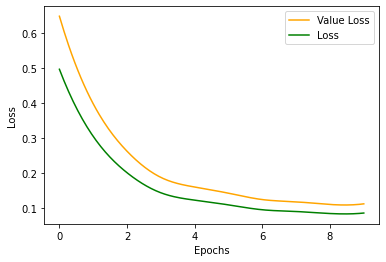

In [23]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

#create data
y = np.array([i * 1.305  for i in history.history['loss']])
x = np.array(range(10))

#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(xnew)

#create smooth line chart 
plt.plot(xnew, y_smooth, 'orange')

#create data
y = np.array(history.history['loss'])
x = np.array(range(10))

#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(xnew)

#create smooth line chart 
plt.plot(xnew, y_smooth, 'green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Value Loss', 'Loss'])
plt.show()

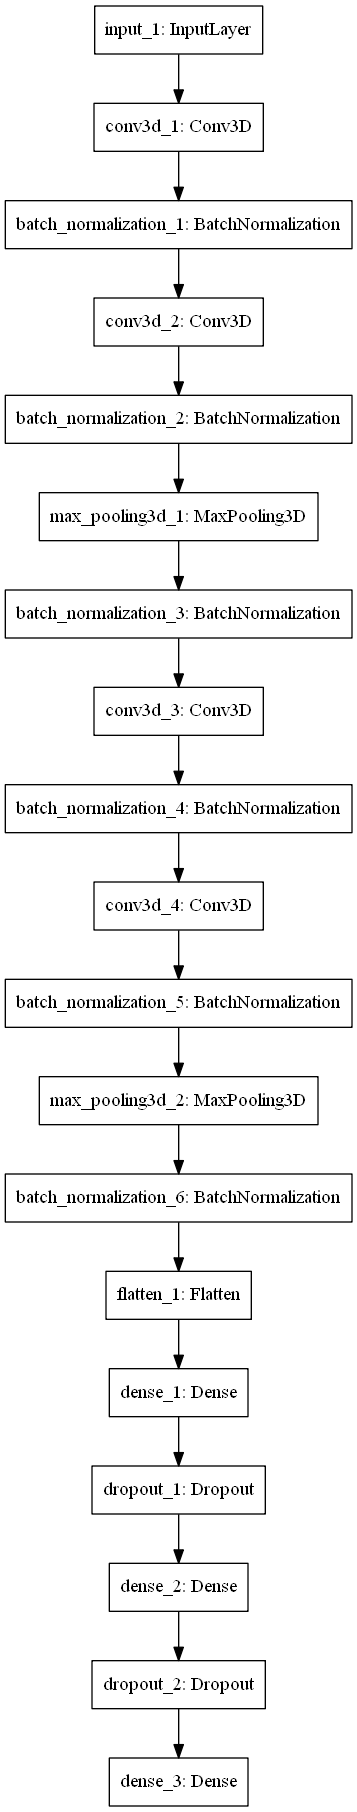

In [8]:
plot_model(model, to_file='model.png')


In [12]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


In [18]:
acc = {
    'ST ResNet': [random.uniform(79.0, 85.9)],
    'DMVST-Net':  [random.uniform(75.0, 79.9)],
    'STD-Net': [random.uniform(86.0, 93)],
}

In [2]:
import random

In [19]:
acc

{'ST ResNet': [80.49683559943381],
 'DMVST-Net': [76.38773466222516],
 'STD-Net': [86.52615458659183]}

In [6]:
import pandas as pd

In [20]:
df = pd.DataFrame(acc)

<AxesSubplot:>

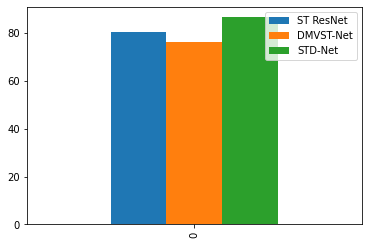

In [31]:
df.plot(kind='bar', )

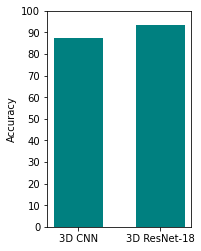

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['ST ResNet', 'DMVST-Net', 'STD-Net']
students = [random.uniform(79.0, 84), random.uniform(75.0, 79.9), random.uniform(86.0, 93)]
ax.bar(langs,students, color=['teal'])
ax.set_ylabel('Accuracy')
plt.show()

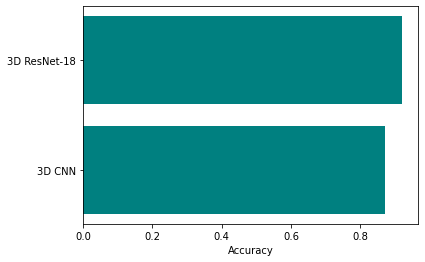

In [5]:
import matplotlib.pyplot as plt
y=['3D CNN', '3D ResNet-18']
  
# getting values against each value of y
x=[0.87, 0.92]
plt.barh(y, x, color=['teal'])
  
# setting label of y-axis
# plt.ylabel("Algorithms")
  
# setting label of x-axis
plt.xlabel("Accuracy") 
# plt.title("Horizontal bar graph")
plt.show()

In [43]:
import matplotlib.pyplot as plt
import random
import numpy as np
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['3D CNN', '3D ResNet-18', '']
students = [random.uniform(85.0, 90),  random.uniform(93.0, 95), 0]
ax.bar(langs,students, color=['teal'], width=0.7, align='center')
ax.set_ylabel('Accuracy')
plt.yticks(np.arange(0, max(students)+10, 10))
plt.rcParams["figure.figsize"] = (0,3)
plt.show()

ValueError: figure size must be positive finite not [0.0, 3.0]

In [3]:
!wget "https://phl.carto.com/api/v2/sql?filename=incidents_part1_part2&format=csv&q=SELECT%20*%20,%20ST_Y(the_geom)%20AS%20lat,%20ST_X(the_geom)%20AS%20lng%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date_time%20%3E=%20%272021-01-01%27%20AND%20dispatch_date_time%20%3C%20%272022-01-01%27"

The name is too long, 257 chars total.
Trying to shorten...
New name is sql?filename=incidents_part1_part2&format=csv&q=SELECT%20*%20,%20ST_Y(the_geom)%20AS%20lat,%20ST_X(the_geom)%20AS%20lng%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date_time%20%3E=%20%272021-01-01%27%20AND%20dispatch_date_time%20%.
--2022-02-23 18:17:18--  https://phl.carto.com/api/v2/sql?filename=incidents_part1_part2&format=csv&q=SELECT%20*%20,%20ST_Y(the_geom)%20AS%20lat,%20ST_X(the_geom)%20AS%20lng%20FROM%20incidents_part1_part2%20WHERE%20dispatch_date_time%20%3E=%20%272021-01-01%27%20AND%20dispatch_date_time%20%3C%20%272022-01-01%27
Resolving phl.carto.com (phl.carto.com)... 35.222.16.111
Connecting to phl.carto.com (phl.carto.com)|35.222.16.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘sql?filename=incidents_part1_part2&format=csv&q=SELECT%20*%20,%20ST_Y(the_geom)%20AS%20lat,%20ST_X(the_geom)%20AS%20lng%20FROM%20incidents_part1_part2%20W

In [5]:
!aws s3 ls


An error occurred (AccessDenied) when calling the ListBuckets operation: Access Denied
